In [24]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pip install faiss-gpu
!pip install timm

In [40]:
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.spatial import distance
import numpy as np
import os
import pandas as pd
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.spatial import distance
import numpy as np

import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import faiss
from natsort import natsorted

import argparse
import os
from pprint import pformat
import logging
import time
from multiprocessing import cpu_count
import sys
from typing import List, Dict, Any, Optional, Tuple, Callable

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from PIL import Image
from typing import List
import io
import torch
import json
import base64
import uuid
import numpy as np
import pandas as pd
import os
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from scipy.spatial import distance

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


class Resnet50(nn.Module):

    """
    Embedding extraction usimong Resnet-50 backbone

    Parameters
    ----------
    embedding_size:
        Size of embedding vector.

    pretrained:
        Whether to use pretrained weight on ImageNet.
    """
    def __init__(self, embedding_size: int, pretrained=False):
        super().__init__()

        model = models.resnet50(pretrained=pretrained)
        # Features extraction layers without the last fully-connected
        self.features = nn.Sequential(*list(model.children())[:-1])
        # Embeddding layer
        self.embedding = nn.Sequential(
            nn.Linear(in_features=2048, out_features=embedding_size)
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Extract embedding features from image.

        Parameters
        ----------
        image:
            RGB image [3 x H x W].

        Returns
        -------
        torch.Tensor
            Embedding vector
        """
        embedding: torch.Tensor = self.features(image)
        embedding = embedding.flatten(start_dim=1)

        embedding: torch.Tensor = self.embedding(embedding)
        embedding = F.normalize(embedding, p=2, dim=1)
        return embedding

plt.rcParams['figure.figsize'] = (30, 30)
plt.rcParams['figure.dpi'] = 150


ALLOWED_EXTENSIONS: Tuple[str] = (
    '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'
)


class Dataset(torch.utils.data.Dataset):
    def __init__(self, images_list: list, transform: Callable, labeled_folders: bool = False):
        self.images_list = images_list
        self.transform = transform
        self.labeled_folders: bool = labeled_folders
        self.samples: List[Tuple[str, Optional[str]]] = self.__get_all_samples()

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[str, Optional[str]]:
        image_path, label = self.samples[index]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return image, label

    def __get_all_samples(self) -> List[Tuple[str, Optional[str]]]:
        samples: List[Tuple[str, Optional[str]]] = []
        for image_path in self.images_list:
            if Dataset.has_allowed_extension(image_path):
                label: str = ""
                if self.labeled_folders:
                    label = os.path.basename(os.path.dirname(image_path))
                samples.append((image_path, label))
        return samples

    @classmethod
    def has_allowed_extension(cls, image_name: str) -> bool:
        return image_name.lower().endswith(ALLOWED_EXTENSIONS)



def get_embedding(model: torch.nn.Module,
                  image_path: str,
                  transform: Callable,
                  device: torch.device
                  ) -> np.ndarray:
    image: Image.Image = Image.open(image_path).convert("RGB")
    input_tensor: torch.Tensor = transform(image).unsqueeze(dim=0).to(device)
    embedding: torch.Tensor = model(input_tensor)
    return embedding.detach().cpu().numpy()


@torch.no_grad()
def get_embeddings_from_dataloader(loader: DataLoader,
                                   model: torch.nn.Module,
                                   device: torch.device,
                                   ) -> Tuple[np.ndarray, Optional[List[str]], List[str]]:
    model.eval()

    embeddings_ls: List[torch.Tensor] = []
    labels_ls: List[str] = []
    for images_, labels_ in loader:
        images: torch.Tensor = images_.to(device, non_blocking=True)
        embeddings: torch.Tensor = model(images)
        embeddings_ls.append(embeddings)
        labels_ls.extend(labels_)

    embeddings: torch.Tensor = torch.cat(embeddings_ls, dim=0)  # shape: [N x embedding_size]

    images_paths: List[str] = []
    for image_path, _ in loader.dataset.samples:
        images_paths.append(image_path)
    return (embeddings.cpu().numpy(), labels_ls, images_paths)


def query(index: faiss.IndexFlatL2,
          query_embedding: np.ndarray,
          k_queries: int,
          ref_image_paths: List[str],
          ) -> Tuple[List[str], List[int], List[float]]:

    # Searching using nearest neighbors in reference set
    # indices: shape [N_embeddings x k_queries]
    # distances: shape [N_embeddings x k_queries]
    distances, indices = index.search(query_embedding, k_queries)
    indices: List[int] = indices.ravel().tolist()
    distances: List[float] = distances.ravel().tolist()
    image_paths: List[str] = [ref_image_paths[i] for i in indices]
    return image_paths, indices, distances


def visualize_query(query_image_path: str,
                    retrieved_image_paths: List[str],
                    retrieved_distances: List[float],
                    retrieved_labels: Optional[List[str]] = None,
                    query_name: Optional[str] = "",
                    image_size=(224, 224)):

    n_retrieved_images: int = len(retrieved_image_paths)
    nrows: int = 2 + (n_retrieved_images - 1) // 3

    _, axs = plt.subplots(nrows=nrows, ncols=3)

    # Plot query image
    query_image: np.ndarray = cv2.imread(query_image_path, cv2.IMREAD_COLOR)
    query_image = cv2.resize(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB), image_size)
    axs[0, 1].imshow(query_image)
    title: str = "Query"
    if query_name:
        title: str = f"Query: {query_name}"
    axs[0, 1].set_title(title, fontsize=30)

    # Plot retrieved images
    for i in range(n_retrieved_images):
        row: int = i // 3 + 1
        col: int = i % 3

        retrieved_image: np.ndarray = cv2.imread(retrieved_image_paths[i], cv2.IMREAD_COLOR)
        retrieved_image = cv2.resize(cv2.cvtColor(retrieved_image, cv2.COLOR_BGR2RGB), image_size)
        distance: float = round(retrieved_distances[i], 4)
        axs[row, col].imshow(retrieved_image)

        # Extract filename without extension
        filename_without_ext = os.path.splitext(os.path.basename(retrieved_image_paths[i]))[0]

        title: str = f"Top {i + 1} ({filename_without_ext})\nDistance: {distance}"
        if retrieved_labels:
            label: str = retrieved_labels[i]
            title = f"Top {i + 1} ({filename_without_ext}): {label}\nDistance: {distance}"
        axs[row, col].set_title(title, fontsize=30)

    # Turn off axis for all plots
    for ax in axs.ravel():
        ax.axis("off")

    return axs

def plot_images_with_labels(image_paths, distances):
    n = len(image_paths)
    fig, axes = plt.subplots(1, n, figsize=(20, 5))

    for ax, img_path, dist in zip(axes, image_paths, distances):
        # 이미지 불러오기
        img = Image.open(img_path)
        ax.imshow(img)

        # 이미지 이름과 거리 정보 추출
        title = f"{img_path.split('/')[-1]}\nDistance: {dist:.3f}"

        # 이미지 위에 제목 설정
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def adjust_filename(filename):
    name, num = filename.rsplit('_', 1)
    num = num.split('.', 1)[0] # split the extension from num and take the first part
    if len(num) > 2:
        num = num[:2]
    return f"{name}_{num}.jpg"

from PIL import Image
import matplotlib.pyplot as plt

def nosePrint(dogname):
  image_paths = [
      "/content/drive/MyDrive/dog_nose/test_images/"+dogname+".jpg",
      "/content/drive/MyDrive/dog_nose/test_images/nose/"+dogname+".jpg",
      "/content/drive/MyDrive/swin2sr/results/swin2sr_real_sr_x4/nose_Swin2SR.png"
  ]
  name = ['origin', 'noseDetect', 'Upscaling']

  # 한번에 모든 이미지 출력
  plt.figure(figsize=(15, 5))

  for idx, path in enumerate(image_paths):
      plt.subplot(1, 3, idx+1)
      img = Image.open(path)
      plt.imshow(img)
      plt.title(name[idx])  # 이미지 파일명을 제목으로 설정
      plt.axis('off')

  plt.tight_layout()
  plt.show()

import matplotlib.pyplot as plt

def plot_similar_images(original_img_path, result_df, image_dir):
    # 원본 이미지를 먼저 표시
    fig = plt.figure(figsize=(15, 7))

    ax = fig.add_subplot(1, 11, 1) # 1행 11열 중 1번째 (원본 + 10개의 유사 이미지)
    original_img = image.load_img(original_img_path, target_size=(380, 380))
    ax.imshow(original_img)
    ax.set_title("Original Image")
    ax.axis('off')

    # 상위 10개의 유사 이미지 표시
    for i, filename in enumerate(result_df['filename'].values, 2):
        img_path = os.path.join(image_dir, filename)

        try:
            img = image.load_img(img_path, target_size=(380, 380))
            ax = fig.add_subplot(1, 11, i)
            ax.imshow(img)
            ax.set_title(f"Top {i-1}")
            ax.axis('off')
        except FileNotFoundError:
            print(f"{img_path} not found. Skipping...")
            continue

    plt.tight_layout()
    plt.show()

In [5]:
# detect 모델
detect_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/yolov5/runs/train/results3/weights/best.pt', force_reload=True)

# featureExtracting 모델
featureModel = EfficientNetB4(weights='imagenet', include_top=False)

# classification 모델
k_queries = 10
checkpoint_path = '/content/drive/MyDrive/deep-metric-learning-tsinghua-dogs/src/checkpoints/softtriple-resnet50.pth'

# Initialize device
device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load model's checkpoint
checkpoint: Dict[str, Any] = torch.load(checkpoint_path, map_location="cpu")

# Load config
config: Dict[str, Any] = checkpoint["config"]
classificationModel = Resnet50(config["embedding_size"])
classificationModel.load_state_dict(checkpoint["model_state_dict"])
classificationModel = classificationModel.to(device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.9 MB/s eta

71686520/71686520 [==============================] - 3s 0us/step


In [35]:
def noseDetect(dogName) :
  # 코 탐지
  results = detect_model("/content/drive/MyDrive/dog_nose/test_images/"+dogname+".jpg")
  results_json = json.loads(results.pandas().xyxy[0].to_json(orient="records"))
  xmin = results_json[0]['xmin']
  ymin = results_json[0]['ymin']
  xmax = results_json[0]['xmax']
  ymax = results_json[0]['ymax']
  input_image = Image.open("/content/drive/MyDrive/dog_nose/test_images/"+dogname+".jpg").convert("RGB")
  noseImg = input_image.crop((xmin, ymin, xmax, ymax))
  noseImg.save('/content/drive/MyDrive/dog_nose/test_images/nose/'+dogName+'.jpg')
  noseImg.save('/content/drive/MyDrive/dog_nose/test_images/upscale/nose.jpg')

  os.chdir("./swin2sr")

  ! python main_test_swin2sr.py --task real_sr --scale 4 --training_patch_size 48 --model_path model_zoo/swin2sr/Swin2SR_RealworldSR_X4_64_BSRGAN_PSNR.pth --folder_lq /content/drive/MyDrive/dog_nose/test_images/upscale --save_img_only

  %cd ..
  %matplotlib inline
  nosePrint(dogName)

In [21]:
def noseFeature(dogName):
  # 이미지 불러오기
  img1_path = "/content/drive/MyDrive/dog_nose/test_images/nose/"+dogName+".jpg"
  img1 = image.load_img(img1_path, target_size=(380, 380))
  x1 = image.img_to_array(img1)
  x1 = np.expand_dims(x1, axis=0)
  x1 = preprocess_input(x1)
  features1 = featureModel.predict(x1, verbose=0)  # 추가: verbose=0
  features1 = features1.flatten()

  # 비교할 이미지가 있는 디렉토리 경로
  image_dir = "/content/drive/MyDrive/yolov5/runs/detect/exp/crops/nose"

  # 결과를 저장할 데이터프레임 생성
  result_df = pd.DataFrame(columns=['filename', 'similarity'])

  for filename in os.listdir(image_dir):
    img2_path = os.path.join(image_dir, filename)

    # 디렉토리인 경우 건너뛰기
    if os.path.isdir(img2_path):
        continue

    try:
        # 비교할 이미지 불러오기
        img2 = image.load_img(img2_path, target_size=(380, 380))
        x2 = image.img_to_array(img2)
        x2 = np.expand_dims(x2, axis=0)
        x2 = preprocess_input(x2)
        features2 = featureModel.predict(x2, verbose=0)  # 추가: verbose=0
        features2 = features2.flatten()

        # 유사도 계산
        similarity = 1 - distance.cosine(features1, features2)

        # 결과 저장 (DataFrame.concat 사용)
        result_df = pd.concat([result_df, pd.DataFrame({'filename': [filename], 'similarity': [similarity]})], ignore_index=True)

    except FileNotFoundError:
        continue


  result_df = result_df.sort_values(by='similarity', ascending=False)
  result_df = result_df[:10]
  result_df['filename'] = result_df['filename'].apply(adjust_filename)

  # 위에서 정의한 함수를 호출하여 이미지를 표시
  plot_similar_images(img1_path, result_df, image_dir)

  # assuming df is your DataFrame and "path" is the directory containing the files
  result_df['filename'] = result_df['filename'].apply(lambda x: '/content/drive/MyDrive/DogDataset/' + x)
  reference_images_dir = result_df['filename']

  return result_df, reference_images_dir

In [11]:
def classification(result_df, reference_images_dir, dogName):
  # Initialize batch size and n_workers
  batch_size: int = config.get("batch_size", None)
  if not batch_size:
      batch_size = config["classes_per_batch"] * config["samples_per_class"]
  n_cpus: int = cpu_count()
  if n_cpus >= batch_size:
      n_workers: int = batch_size
  else:
      n_workers: int = n_cpus
  # Initialize transform
  transform = T.Compose([
      T.Resize((config["image_size"], config["image_size"])),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      ),
  ])

  # Initialize reference set and reference loader
  reference_set = Dataset(reference_images_dir, transform=transform)
  reference_loader = DataLoader(reference_set, batch_size=batch_size, shuffle=False, num_workers=n_workers)

  # Calculate embeddings from images in reference set
  ref_embeddings, ref_labels, ref_image_paths = get_embeddings_from_dataloader(
    reference_loader, classificationModel, device
  )

  # Indexing database to search
  index = faiss.IndexFlatL2(config["embedding_size"])
  index.add(ref_embeddings)

  testImgPath = "/content/drive/MyDrive/dog_nose/test_images/"+dogName+".jpg"
  image_path = testImgPath

  # Retrive k most similar images in reference set
  start = time.time()
  embedding: np.ndarray = get_embedding(classificationModel, image_path, transform, device)
  retrieved_image_paths, retrieved_indices, retrieved_distances = query(
      index, embedding, k_queries, ref_image_paths
  )
  if ref_labels:
      retrieved_labels: List[str] = [ref_labels[i] for i in retrieved_indices]
  end = time.time()

  plot_images_with_labels(retrieved_image_paths, retrieved_distances)



/content/drive/MyDrive
loading model from model_zoo/swin2sr/Swin2SR_RealworldSR_X4_64_BSRGAN_PSNR.pth
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Testing 0 nose                
/content/drive/MyDrive


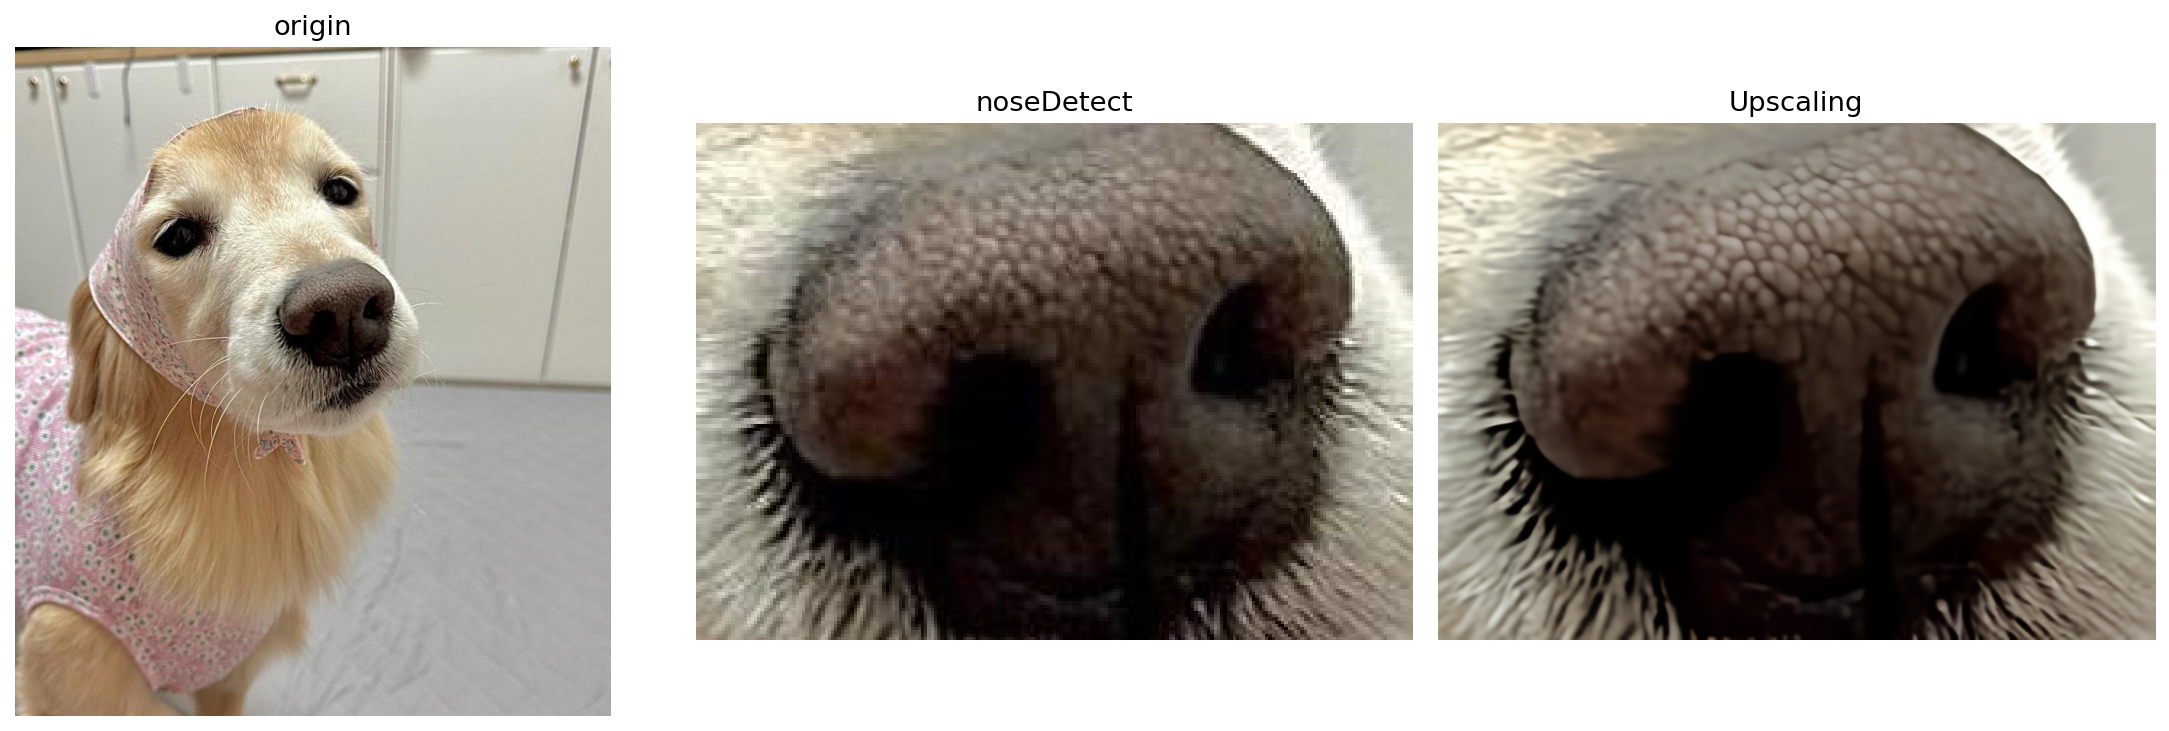

/content/drive


In [45]:
%cd /content/drive/MyDrive
dogname = "dog5_1"
noseDetect(dogname) #약 15초 소요
%cd ..

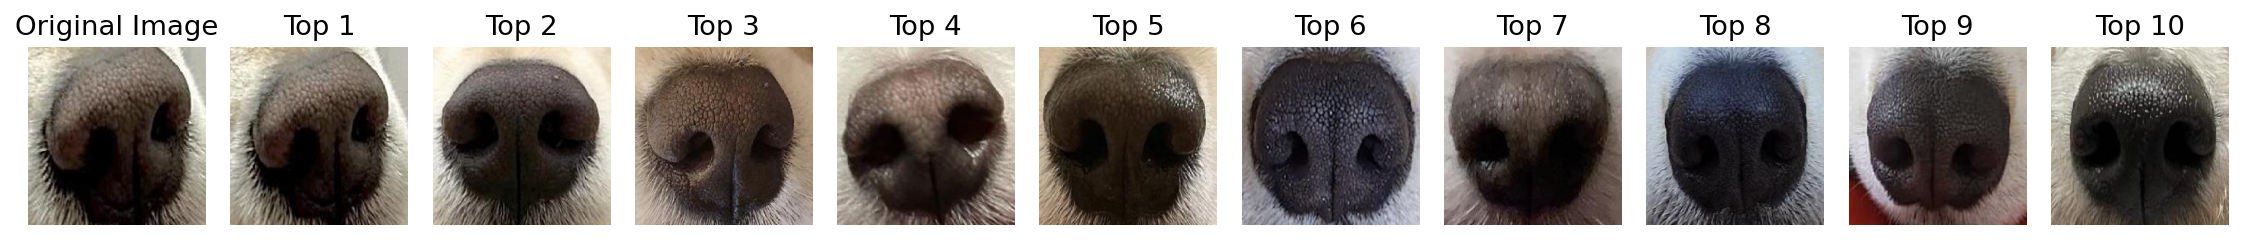

In [46]:
result_df, reference_images_dir = noseFeature(dogname) #약 40초 소요

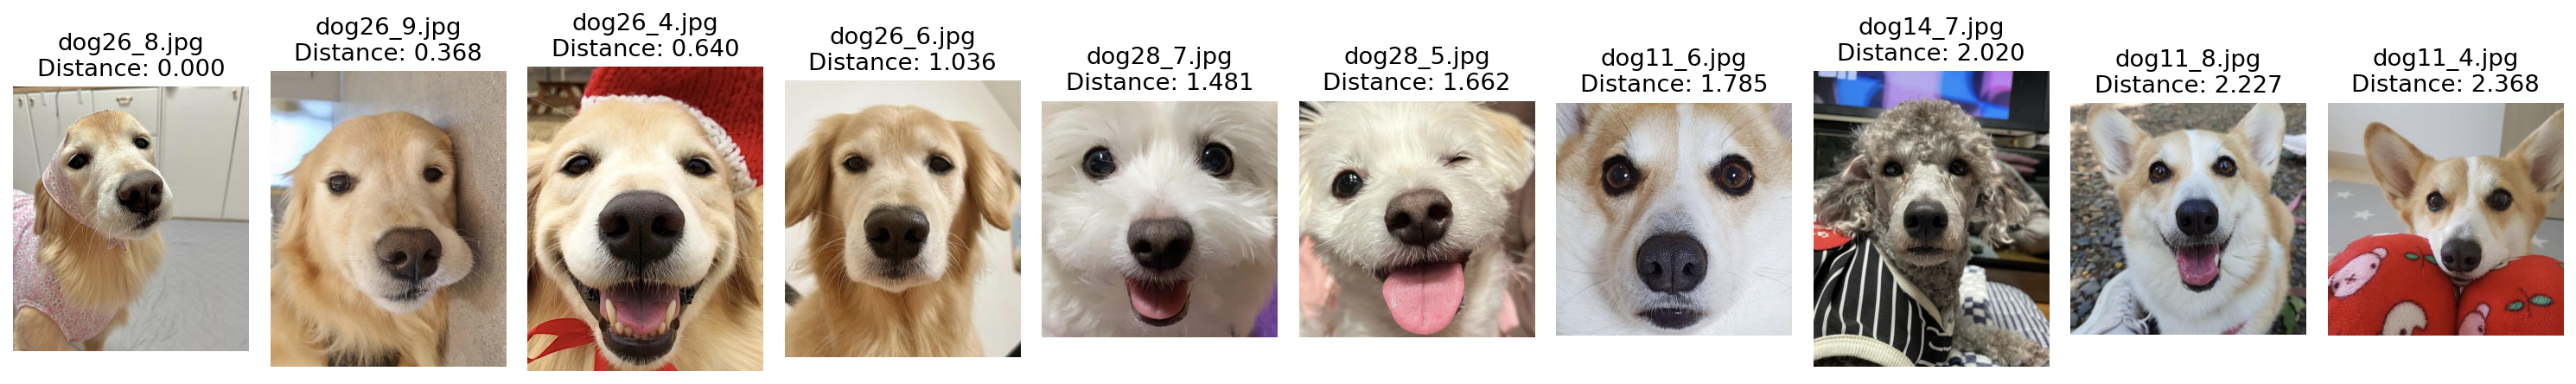

In [47]:
classification(result_df, reference_images_dir, dogname)